이 모델은 다층 신경망(Deep Neural Network) 기반으로 설계된 이진 분류 모델입니다. 입력층과 3개의 은닉층(뉴런 수 512, 256, 128), 배치 정규화(Batch Normalization), 드롭아웃(Dropout)을 통해 과적합을 방지하며, 출력층은 시그모이드 활성화 함수로 0~1 사이의 확률 값을 반환합니다. 학습 과정에서 Adam 옵티마이저와 이진 크로스엔트로피 손실 함수를 사용하며, EarlyStopping으로 최적의 학습 상태를 유지해 일반화 성능을 극대화합니다.

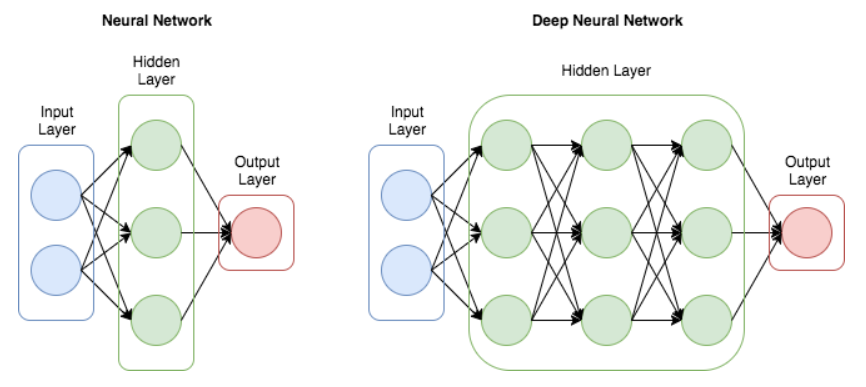


In [100]:
import json
import pandas as pd

json_file = 'clinical.project-tcga-brca.2024-11-22.json'

with open(json_file, 'r') as f:
    data = json.load(f)

records = []

for record in data:
    case_id = record.get("case_id", "")
    submitter_id = record.get("submitter_id", "")
    project_id = record.get("project", {}).get("project_id", "")

    demographic = record.get("demographic", {})
    demographic_id = demographic.get("demographic_id", "")
    ethnicity = demographic.get("ethnicity", "")
    gender = demographic.get("gender", "")
    race = demographic.get("race", "")
    age_at_index = demographic.get("age_at_index", "")
    vital_status = demographic.get("vital_status", "")

    diagnoses = record.get("diagnoses", [])
    for diagnosis in diagnoses:
        diagnosis_id = diagnosis.get("diagnosis_id", "")
        age_at_diagnosis = diagnosis.get("age_at_diagnosis", "")
        primary_diagnosis = diagnosis.get("primary_diagnosis", "")
        ajcc_pathologic_stage = diagnosis.get("ajcc_pathologic_stage", "")
        tissue_or_organ_of_origin = diagnosis.get("tissue_or_organ_of_origin", "")

        treatments = diagnosis.get("treatments", [])
        for treatment in treatments:
            treatment_id = treatment.get("treatment_id", "")
            treatment_type = treatment.get("treatment_type", "")
            treatment_or_therapy = treatment.get("treatment_or_therapy", "")

            exposures = record.get("exposures", [])
            for exposure in exposures:
                exposure_id = exposure.get("exposure_id", "")
                alcohol_history = exposure.get("alcohol_history", "")

                records.append({
                    "case_id": case_id,
                    "submitter_id": submitter_id,
                    "project_id": project_id,
                    "demographic_id": demographic_id,
                    "ethnicity": ethnicity,
                    "gender": gender,
                    "race": race,
                    "age_at_index": age_at_index,
                    "vital_status": vital_status,
                    "diagnosis_id": diagnosis_id,
                    "age_at_diagnosis": age_at_diagnosis,
                    "primary_diagnosis": primary_diagnosis,
                    "ajcc_pathologic_stage": ajcc_pathologic_stage,
                    "tissue_or_organ_of_origin": tissue_or_organ_of_origin,
                    "treatment_id": treatment_id,
                    "treatment_type": treatment_type,
                    "treatment_or_therapy": treatment_or_therapy,
                    "exposure_id": exposure_id,
                    "alcohol_history": alcohol_history
                })

In [101]:
df = pd.DataFrame(records)
df['age_at_diagnosis'].replace('', np.nan, inplace=True)
df['age_at_diagnosis'].fillna(df['age_at_diagnosis'].median(), inplace=True)

df.fillna("unknown", inplace=True)
df = pd.get_dummies(df, columns=['gender', 'race', 'ethnicity', 'ajcc_pathologic_stage'], drop_first=True)
df.drop(columns=['case_id', 'submitter_id', 'project_id', 'demographic_id', 'diagnosis_id', 'exposure_id', 'treatment_id'], inplace=True)
df.to_csv('clinical_data.csv', index=False)

<ipython-input-101-8e8d9606c5c8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age_at_diagnosis'].replace('', np.nan, inplace=True)
<ipython-input-101-8e8d9606c5c8>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['age_at_diagnosis'].replace('', np.nan, inplace=True)


In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.combine import SMOTEENN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 데이터 준비 및 전처리
df['vital_status'] = df['vital_status'].map({'Alive': 1, 'Dead': 0})
categorical_cols = ['primary_diagnosis', 'tissue_or_organ_of_origin', 'treatment_type', 'treatment_or_therapy', 'alcohol_history']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df.drop(columns=['vital_status'])
y = df['vital_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 불균형 데이터 처리
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# 모델 설계
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # 이진 분류
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_resampled, y_train_resampled, validation_split=0.2, epochs=200, batch_size=32)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5841 - loss: 0.6950 - val_accuracy: 0.6134 - val_loss: 0.6917
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7503 - loss: 0.5014 - val_accuracy: 0.7542 - val_loss: 0.6204
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7802 - loss: 0.4742 - val_accuracy: 0.7828 - val_loss: 0.5554
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8028 - loss: 0.4247 - val_accuracy: 0.7685 - val_loss: 0.5076
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7880 - loss: 0.4260 - val_accuracy: 0.7995 - val_loss: 0.4717
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8355 - loss: 0.3478 - val_accuracy: 0.7947 - val_loss: 0.4543
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8246 - loss: 0.3608 - val_accuracy: 0.8019 - val_loss: 0.4346
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8323 - loss: 0.3386 - val_accuracy: 0.7828

In [103]:
y_pred = model.predict(X_test)

y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.9938724373576309


In [ ]:
# 데이터 시각화 코드 추가
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 학습 과정의 정확도 및 손실 시각화
plt.figure(figsize=(12, 5))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# 손실
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# 클래스 불균형 전후 시각화
plt.figure(figsize=(10, 5))

# 원본 데이터 클래스 분포
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# 샘플링 후 데이터 클래스 분포
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# 주요 결과 시각화 (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dead", "Alive"])

disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()
